# Part 2: Community simulation with dynamic FBA

In this tutorial, you are setting up a microbial community model and simulate it with a simplistic dynamic FBA scheme using [cobrapy](https://cobrapy.readthedocs.io) for the FBA solutions and the [integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function of scipy for the dynamic simulation.

The community is a composition of yeast and an *Escherichia coli* strain that is assumed to be able to metabolize ethanol if oxygen is available. This *E. coli* model is meant as a substitute for *Acetobacter aceti* for which we don't have a suitable curated metabolic network reconstruction.

The FBA models are in SBML format, and available from the [BiGG model database](http://bigg.ucsd.edu) as:

* Yeast: http://bigg.ucsd.edu/models/iMM904
* *E. coli*: http://bigg.ucsd.edu/models/iECW_1372

We assume initially aerobic conditions, however, oxygen transfer is assumed to be slow and will become limiting at high metabolic activities.

First, the two models will be downloaded an analysed individually with FBA to get a first idea of the relevant exchange constraints and fluxes.

Then, dynamic FBA models for each species individually will be simulated.

Finally, you will combine the two DFBA models into a single community model and simulate that.

## General instructions

* You generally need to run all the code cells below in sequence. Some of them may be incomplete or empty, follow the instructions to work out a code solution for them.
* Explanatory text comes in markup text cells that have already be formatted, you can skip over these.

First import some required packages for the tutorial:

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot
import warnings
import os.path
import urllib.request

On Google Colaboratory we need to install cobra via pip first.

In [2]:
# !pip install cobra

In [3]:
import cobra

Download the FBA models if they are not present:

In [4]:
if not os.path.exists("iMM904.xml"):
    urllib.request.urlretrieve("http://bigg.ucsd.edu/static/models/iMM904.xml", "iMM904.xml")
if not os.path.exists("iECW_1372.xml"):
    urllib.request.urlretrieve("http://bigg.ucsd.edu/static/models/iECW_1372.xml", "iECW_1372.xml")

The models can now be loaded into cobra as follows:

In [5]:
sc_model = cobra.io.read_sbml_model("iMM904.xml")
ec_model = cobra.io.read_sbml_model("iECW_1372.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-23


## FBA and dynamic FBA for the yeast model

Let's have a first look at the yeast model by just running FBA on it.

The ``.summary()`` method in cobra displays exchange fluxes from the most recent FBA optimization:

In [6]:
sc_sol = sc_model.optimize()
print(sc_model.summary())

Objective
1.0 BIOMASS_SC5_notrace = 0.2878657037040172

Uptake
------
Metabolite    Reaction    Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e      10         6 100.00%
     nh4_e    EX_nh4_e   1.611         0   0.00%
      o2_e     EX_o2_e       2         0   0.00%
      pi_e     EX_pi_e 0.05691         0   0.00%
     so4_e    EX_so4_e 0.02225         0   0.00%

Secretion
---------
Metabolite  Reaction      Flux  C-Number C-Flux
     co2_e  EX_co2_e    -18.02         1 36.29%
    etoh_e EX_etoh_e    -15.82         2 63.70%
     for_e  EX_for_e -0.001488         1  0.00%
     h2o_e  EX_h2o_e     -5.64         0  0.00%
       h_e    EX_h_e     -1.45         0  0.00%



In the nominal version of the model, both glucose and oxygen uptake have been constrained to empirical values.
To prepare for a dynamic FBA model, let's see what happens when we allow higher oxygen uptake (meaning a more negative lower bound on the exchange flux).
In addition, we set a tighter bound on the ammonium uptake to model reduced nitrogen availability.

In [7]:
with sc_model:
    sc_model.exchanges.EX_o2_e.lower_bound = -40.0
    sc_model.exchanges.EX_nh4_e.lower_bound = -5.0
    sc_model.optimize()
    print(sc_model.summary())

Objective
1.0 BIOMASS_SC5_notrace = 0.8934219131379548

Uptake
------
Metabolite    Reaction    Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e   9.254         6 100.00%
     nh4_e    EX_nh4_e       5         0   0.00%
      o2_e     EX_o2_e   22.77         0   0.00%
      pi_e     EX_pi_e  0.1766         0   0.00%
     so4_e    EX_so4_e 0.06906         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -23.41         1 100.00%
     h2o_e EX_h2o_e -34.07         0   0.00%
       h_e   EX_h_e -4.494         0   0.00%



### Dynamic FBA for the yeast model

To set up the dynamic FBA model, we define a few required parameters that describe kinetics of glucose uptake and oxygen transfer rates as well as cellular uptake of oxygen.

In [8]:
V_max_glc = 10.0 # maximum rate of glucose uptake (bound from nominal FBA model).
K_m_glc = 0.01 # Michaelis-Menten constant for glucose uptake (empirical)
V_max_o2 = 20.0
K_m_o2 = 0.1
kLa_o2 = 10.0 # this value corresponds to a rather low rate of oxygen exchange.
V_max_nh4 = 5.0 # assuming limited nitrogen availability

The following function definition is the core of the dynamic FBA construction.
The function will be used as the right hand side of a differential equation model.

Internally, it computes the rate of change of the dynamic metabolites and biomass by solving the underlying FBA model.
However, before the FBA model is solved, the exchange constraints are updated from the current metabolite concentrations, using the assumed kinetics for the uptake reactions.

The dynamic variables, accessed through the vector ``x``, have the following meaning:
* ``x[0]`` is yeast biomass in g/L.
* ``x[1]`` is not used (remains constant), will be *E. coli* biomass later.
* ``x[2]`` is glucose concentration in g/L.
* ``x[3]`` is (dissolved) oxygen concentration in mg/L.
* ``x[4]`` is ethanol concentration in g/L.

In [9]:
def sc_dfba(t, x):
    xdot = 0*x
    # oxygen transfer is modelled by linear diffusive transport w.r.t. a saturation concentration of 10 mg/L.
    xdot[3] = kLa_o2 * (10.0 - x[3]) # oxygen gas transfer in mg/L
    with sc_model:
        # Michaelis-Menten kinetics for glucose and oxygen uptake
        sc_model.exchanges.EX_glc__D_e.lower_bound = - V_max_glc * x[2] / (K_m_glc + x[2]) if x[2] > 0 else 0.0
        sc_model.exchanges.EX_o2_e.lower_bound = - V_max_o2 * x[3] / (K_m_o2 + x[3]) if x[3] > 0 else 0.0
        sc_model.exchanges.EX_nh4_e.lower_bound = - V_max_nh4 # dynamics for NH4 are not included in the model.
        sc_sol = sc_model.optimize()
        # only use the FBA solution if the solver was successful, otherwise all fluxes are assumed to be 0.
        if sc_sol.status == "optimal":
            xdot[0] += sc_sol.fluxes['BIOMASS_SC5_notrace'] * x[0]
            xdot[2] += sc_sol.fluxes['EX_glc__D_e'] * 0.18 * x[0] # molecular mass 0.18 g/mmol
            xdot[3] += sc_sol.fluxes['EX_o2_e'] * 32 * x[0] # molecular mass 32 mg/mmol
            xdot[4] += sc_sol.fluxes['EX_etoh_e'] * 0.046 * x[0] # in g/L
    return xdot

Having defined the right hand side for the dynamic FBA model, we can now simulate the resulting differential equation model with the help of the [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) method.

The ODE solver requires a right hand side as a python function, the simulation time range, and an initial condition which are defined below.

A solver method can also be chosen, due to the stiffness of these models, it is recommended to use an implicit solver relying on backward differentiation formula (BDF).

During the integration, the ODE solver will typically encounter some iterations where the FBA problem is infeasible. Cobrapy generates a warning about that, which may clutter the output. To hide these warnings, we can add a filter from the Python `warnings` module.

In [10]:
tsim = [0, 20]
x0 = np.array([0.01, 0.0, 10.0, 10.0, 0.0]) # yeast biomass, unused, glucose, oxygen, ethanol
with warnings.catch_warnings():
    # uncomment the following line to hide warnings
    # warnings.simplefilter("ignore")
    dfba_sol = integrate.solve_ivp(sc_dfba, tsim, x0, method='BDF')

/opt/miniconda3/envs/cobra/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/miniconda3/envs/cobra/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/miniconda3/envs/cobra/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/miniconda3/envs/cobra/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/miniconda3/envs/cobra/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/miniconda3/envs/cobra/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver sta

The simulation result is stored in the variable `dfba_sol`, and can now be plotted with the matplotlib library.

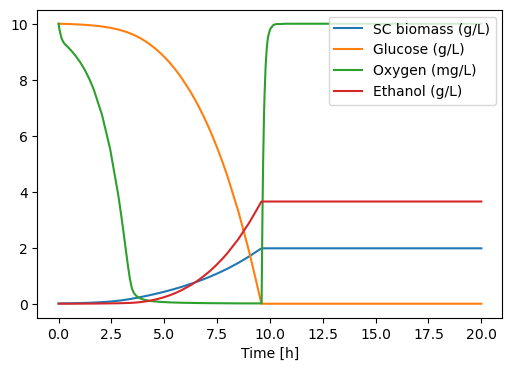

In [11]:
fig, ax = pyplot.subplots(1, 1, figsize=(6,4))
ax.plot(dfba_sol.t, dfba_sol.y[0,:], label="SC biomass (g/L)")
ax.plot(dfba_sol.t, dfba_sol.y[2,:], label="Glucose (g/L)")
ax.plot(dfba_sol.t, dfba_sol.y[3,:], label="Oxygen (mg/L)")
ax.plot(dfba_sol.t, dfba_sol.y[4,:], label="Ethanol (g/L)")
ax.set_xlabel("Time [h]")
# fig.savefig("dfba_sc.png")
ax.legend()

## FBA and dynamic FBA for the *E. coli* model

Let's first check the growth rate and exchange fluxes for nominal conditions as defined in the FBA model:

In [12]:
ec_model.optimize()
ec_model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.005114,0,0.00%
cl_e,EX_cl_e,0.005114,0,0.00%
cobalt2_e,EX_cobalt2_e,2.456E-05,0,0.00%
cu2_e,EX_cu2_e,0.0006966,0,0.00%
fe2_e,EX_fe2_e,0.01578,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1918,0,0.00%
mg2_e,EX_mg2_e,0.008523,0,0.00%
mn2_e,EX_mn2_e,0.0006789,0,0.00%
mobd_e,EX_mobd_e,0.0001267,0,0.00%


In order to use that model as a substitute for *Acetobacter aceti*, we need it to grow on ethanol as a main carbon source under aerobic conditions. To describe these nutrient conditions, we set the lower bound on the glucose exchange rate at 0, and the lower bound on the ethanol exchange rate to a non-zero negative number.

In [13]:
with ec_model:
    # adjust the following bounds to describe a situation with no glucose, but ethanol in the medium
    ec_model.exchanges.EX_glc__D_e.lower_bound = 0.0
    ec_model.exchanges.EX_etoh_e.lower_bound = -10.0
    fba_sol = ec_model.optimize()
    print(ec_model.summary())

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.4219575298408514

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
     ca2_e     EX_ca2_e  0.002196         0   0.00%
      cl_e      EX_cl_e  0.002196         0   0.00%
 cobalt2_e EX_cobalt2_e 1.055E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0002992         0   0.00%
    etoh_e    EX_etoh_e        10         2 100.00%
     fe2_e     EX_fe2_e  0.006777         0   0.00%
       k_e       EX_k_e   0.08236         0   0.00%
     mg2_e     EX_mg2_e   0.00366         0   0.00%
     mn2_e     EX_mn2_e 0.0002916         0   0.00%
    mobd_e    EX_mobd_e 5.443E-05         0   0.00%
     nh4_e     EX_nh4_e     4.557         0   0.00%
     ni2_e     EX_ni2_e 0.0001363         0   0.00%
      o2_e      EX_o2_e     11.78         0   0.00%
      pi_e      EX_pi_e     0.407         0   0.00%
     so4_e     EX_so4_e    0.1064         0   0.00%
     zn2_e     EX_zn2_e 0.0001439         0   0.00%

Secretion
---------
Metabolite    

### Dynamic FBA for the *E. coli* model

The dynamic FBA simulation for the *E. coli* model is set up analogously to the one for the yeast model. It considers the same extracellular metabolites and uses the same components of the `x` vector for these. For simplicity, we also use the same kinetic parameter values.

The main difference is that now the *E. coli* model is used for the internal FBA optimization step, and the biomass is stored in `x[1]` instead of `x[0]`.

Different to the yeast model, here we also permit an uptake of ethanol as a carbon source. This is added to the constraints on the exchange reactions.

The dynamic variables, accessed through the vector ``x``, have the following meaning:
* ``x[0]`` is not used.
* ``x[1]`` is *E. coli* biomass in g/L.
* ``x[2]`` is glucose concentration in g/L.
* ``x[3]`` is (dissolved) oxygen concentration in mg/L.
* ``x[4]`` is ethanol concentration in g/L.

In [14]:
V_max_eth = 10.0
K_m_eth = 0.1

In [15]:
def ec_dfba(t, x):
    xdot = 0*x
    xdot[3] = kLa_o2 * (10.0 - x[3]) # oxygen gas transfer in mg/L
    with ec_model:
        # adjust the bounds on the following exchange fluxes by kinetic expressions
        ec_model.exchanges.EX_glc__D_e.lower_bound = - V_max_glc * x[2] / (K_m_glc + x[2]) if x[2] > 0 else 0.0
        ec_model.exchanges.EX_o2_e.lower_bound = - V_max_o2 * x[3] / (K_m_o2 + x[3]) if x[3] > 0 else 0.0
        ec_model.exchanges.EX_nh4_e.lower_bound = - V_max_nh4 
        ec_model.exchanges.EX_etoh_e.lower_bound = - V_max_eth * x[4] / (K_m_eth + x[4]) if x[4] > 0 else 0.0
        ec_sol = ec_model.optimize()
        if ec_sol.status == "optimal":
            # add the biomass growth and exchange fluxes on glucose and oxygen to xdot
            xdot[1] += ec_sol.fluxes['BIOMASS_Ec_iJO1366_core_53p95M'] * x[1]
            xdot[2] += ec_sol.fluxes['EX_glc__D_e'] * 0.18 * x[1] # molecular mass 0.18 g/mmol
            xdot[3] += ec_sol.fluxes['EX_o2_e'] * 32 * x[1] # molecular mass 32 mg/mmol
            xdot[4] += ec_sol.fluxes['EX_etoh_e'] * 0.046 * x[1] # in g/L
    return xdot

The simulation is started from initial conditions defined in `x0` with positive *E. coli* biomass, glucose in the medium, and full oxygen saturation.

In [16]:
tsim = [0, 20]
# define an initial condition with 0.01 g/L E. coli biomass
x0 = np.array([0.0, 0.01, 10.0, 10.0, 0.0])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dfba_sol = integrate.solve_ivp(ec_dfba, tsim, x0, method='BDF')

The following code plots the simulation results. Notice that ethanol is re-metabolized after glucose runs out.

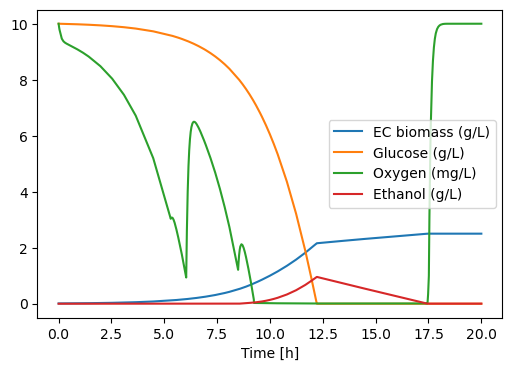

In [17]:
fig, ax = pyplot.subplots(1, 1, figsize=(6,4))
ax.plot(dfba_sol.t, dfba_sol.y[1,:], label="EC biomass (g/L)")
ax.plot(dfba_sol.t, dfba_sol.y[2,:], label="Glucose (g/L)")
ax.plot(dfba_sol.t, dfba_sol.y[3,:], label="Oxygen (mg/L)")
ax.plot(dfba_sol.t, dfba_sol.y[4,:], label="Ethanol (g/L)")
ax.set_xlabel("Time [h]")
# fig.savefig("dfba_ec.png")
ax.legend()

# Dynamic FBA simulation of the yeast / *E. coli* community

For the community simulation, we simply put together the FBA models from the involved strains in the following way:
* Bounds on exchange fluxes are set from the current metabolite concentrations
* Each underlying FBA model is optimized independently in the ODE integration step
* The resulting exchange fluxes on the dynamic extracellular metabolites are summed up from the individual FBA models to get the overall rate of change of each metabolite.

In the community model, the following dynamic variables are thus used:
* ``x[0]`` and ``x[1]`` are yeast and E. coli biomass, respectively.
* ``x[2]`` is glucose concentration.
* ``x[3]`` is oxygen concentration.
* ``x[4]`` is ethanol concentration.

In [20]:
def community_dfba(t, x):
    xdot = 0*x
    xdot[3] = kLa_o2 * (10.0 - x[3]) # oxygen gas transfer in mg/L
    with sc_model:
        # Michaelis-Menten kinetics for glucose and oxygen uptake
        sc_model.exchanges.EX_glc__D_e.lower_bound = - V_max_glc * x[2] / (K_m_glc + x[2]) if x[2] > 0 else 0.0
        sc_model.exchanges.EX_o2_e.lower_bound = - V_max_o2 * x[3] / (K_m_o2 + x[3]) if x[3] > 0 else 0.0
        sc_model.exchanges.EX_nh4_e.lower_bound = - V_max_nh4 # dynamics for NH4 are not included in the model.
        sc_sol = sc_model.optimize()
        # only use the FBA solution if the solver was successful, otherwise all fluxes are assumed to be 0.
        if sc_sol.status == "optimal":
            xdot[0] += sc_sol.fluxes['BIOMASS_SC5_notrace'] * x[0]
            xdot[2] += sc_sol.fluxes['EX_glc__D_e'] * 0.18 * x[0] # molecular mass 0.18 g/mmol
            xdot[3] += sc_sol.fluxes['EX_o2_e'] * 32 * x[0] # molecular mass 32 mg/mmol
            xdot[4] += sc_sol.fluxes['EX_etoh_e'] * 0.046 * x[0] # in g/L
    with ec_model:
        ec_model.exchanges.EX_glc__D_e.lower_bound = - V_max_glc * x[2] / (K_m_glc + x[2]) if x[2] > 0 else 0.0
        ec_model.exchanges.EX_o2_e.lower_bound = - V_max_o2 * x[3] / (K_m_o2 + x[3]) if x[3] > 0 else 0.0
        ec_model.exchanges.EX_nh4_e.lower_bound = - V_max_nh4 
        ec_model.exchanges.EX_etoh_e.lower_bound = - V_max_eth * x[4] / (K_m_eth + x[4]) if x[4] > 0 else 0.0
        ec_sol = ec_model.optimize()
        if ec_sol.status == "optimal":
            xdot[1] += ec_sol.fluxes['BIOMASS_Ec_iJO1366_core_53p95M'] * x[1]
            xdot[2] += ec_sol.fluxes['EX_glc__D_e'] * 0.18 * x[1] # molecular mass 0.18 g/mmol
            xdot[3] += ec_sol.fluxes['EX_o2_e'] * 32 * x[1] # molecular mass 32 mg/mmol
            xdot[4] += ec_sol.fluxes['EX_etoh_e'] * 0.046 * x[1] # in g/L
    return xdot

Again the simulation is run with scipy's `integrate.solve_ivp` method. The initial condition `x0` includes both yeast and *E. coli* biomass, as well as glucose and oxygen in the medium.

Here a slightly longer simulation time should be used, because more ethanol is produced during the early oxygen-limited phase, which is only slowly re-metabolized by the *E. coli* model.

In [21]:
tsim = [0, 30]
x0 = np.array([0.01, 0.01, 10.0, 10.0, 0.0])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dfba_sol = integrate.solve_ivp(community_dfba, tsim, x0, method='BDF')

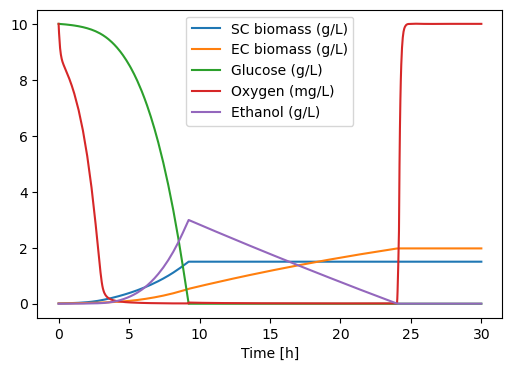

In [22]:
fig, ax = pyplot.subplots(1, 1, figsize=(6,4))
ax.plot(dfba_sol.t, dfba_sol.y[0,:], label="SC biomass (g/L)")
ax.plot(dfba_sol.t, dfba_sol.y[1,:], label="EC biomass (g/L)")
ax.plot(dfba_sol.t, dfba_sol.y[2,:], label="Glucose (g/L)")
ax.plot(dfba_sol.t, dfba_sol.y[3,:], label="Oxygen (mg/L)")
ax.plot(dfba_sol.t, dfba_sol.y[4,:], label="Ethanol (g/L)")
ax.set_xlabel("Time [h]")
# fig.savefig("dfba_community.png")
ax.legend()